# STA 561 HW 5 {-}

Authors  
 -  Alonso Guerrero Castaneda (UID: 1194613)  
 -  Eli Gnesin (UID: 1172961)  
 -  Tommy Misikoff (UID: 1166813)  
 -  Sanskriti Purohit (UID: 1179957)  
 -  Will Tirone (UID: 1130904)  

TA: Rick Presman 

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import random
import numpy.random as nr
from sklearn import datasets

### Question 1 {-}

$$
\begin{aligned}
\mathbb{E}||k^\frac{-1}{2} \Omega \bf{x}||^2 &= k^{-1} \mathbb{E} \bigg| \bigg| \begin{bmatrix}
           \Omega_{1}^T \bf{x} \\
           \vdots \\
           \Omega_{k}^T \bf{x}
         \end{bmatrix}
\bigg| \bigg|^2 \\
&= k^{-1} \mathbb{E} \bigg[ \bigg(\Omega_{1,1} x_1 + \dots + \Omega_{1,k}x_p\bigg)^2 + \dots + \bigg(\Omega_{k,1} x_1 + \dots + \Omega_{k,p}x_p\bigg)^2 \bigg] \\
&= k^{-1} \mathbb{E} \bigg[ [ x_1^2 \Omega_{1,1}^2 + \Omega_{1,1}\Omega_{1,2}x_1x_2 + \dots] + \dots + [x_1^2 \Omega_{k,1}^2 + \dots] \bigg] \\
\end{aligned}
$$

Now the non-squared terms will be 0, since $\mathbb{E}(\Omega_{i,j}) = 0$ and they are i.i.d. For example, $\mathbb{E}(\Omega_{1,1}\Omega_{1,2}x_1x_2) = x_1x_2\mathbb{E} (\Omega_{1,1})\mathbb{E}(\Omega_{1,2}) = 0$

$$
\begin{aligned}
&= k^{-1}  \bigg[ [x_1^2 \mathbb{E}(\Omega_{1,1}^2)  + \dots + x_p^2\mathbb{E}(\Omega_{1,k}^2)] + \dots + [x_1^2 \mathbb{E}(\Omega_{k,1}^2) + \dots + x_p^2\mathbb{E}(\Omega_{k,p}^2)] \bigg] \\ 
&= k^{-1} \bigg[ [x_1^2  + \dots + x_p^2] + \dots + [x_1^2 + \dots + x_p^2 ] \bigg] \ \ \ \ \ \ \ \ \ \ \text{second moment: } \text{Var}(\Omega_{i,j}) = E(\Omega_{i,j}^2) - 0 = 1 \\ 
&= k^{-1} \bigg[ || x ||^2 + \dots + || x ||^2 \bigg] \\ 
&= ||x||^2 \\
\end{aligned}
$$

If we want to generate $\Omega_{i,j} \overset{IID}{\sim} Q$, the necessary conditions for the above proof to hold are that $Q$ has a mean of 0 and a variance of 1.

### Question 2 {-}

$$
\begin{aligned}
\hat{\beta}_n^\Omega &= \Omega^T \text{argmin}_\beta \mathbb{P}_n (Y - (\Omega\bf{X})^T\beta)^2\\
&= \Omega^T((\mathbb{P}_n(\Omega \bf{X})(\Omega \bf{X})^T)^{-1} \mathbb{P}_n(\Omega \bf{X})Y \\ 
&= \Omega^T( \Omega \mathbb{P}_n \bf{X} \textbf{X}^T \Omega^T)^{-1}  \Omega \mathbb{P}_n  {\textbf X} Y
\end{aligned}
$$

Now set $\Sigma = \mathbb{P}_n \bf{X} \bf{X}^T$ and $\Gamma = \mathbb{P}_n  \bf{X} Y$. If our data is very large, say 10 million rows, we can make a single pass through the data to compute these quantities, with the below pseudo code:

```
// initialize
X = data
Y = target
B = number of replicates, chosen by the user
n = length(target)
Sigma = 0
Gamma = 0
Beta = 0

// Loop through and sum
// The goal here is to calculate P_n XX^T and P_n XY exactly once and store them
For i in 1 : n

    // Calculate XX^T and XY
    temp_data = X[i]
    temp_target = Y[i]
    temp_Sigma = temp_data * temp_data^T
    temp_Gamma = temp_data * temp_target
    
    Sigma = Sigma + temp_Sigma
    Gamma = Gamma + temp_Gamma
    
Sigma = (1/n) * Sigma
Gamma = (1/n) * Gamma

// Now loop through our B and calculate beta_hat
For b in 1 : B
    Omega = (k * p matrix randomly sampled from Q)
    Inter = Omega @ Sigma @ Omega^T
    Inv_inter = Inter^{-1}
    projected_beta = Omega^T @ Inv_inter @ Omega @ Gamma
    
    Beta = Beta + projected_beta

Beta = (1/B) * Beta

// RETURN Beta
```

Regardless of the size of our dataset, we calculate $\Sigma$ and $\Gamma$ by iterating through the data once, taking $\bf{X}\bf{X}^T \in \mathbb{R}^{p \times p}$ and $\bf{X}\bf{Y} \in \mathbb{R}^{p \times 1}$ for each $\bf{X}_i, Y_i$ in the dataset, and then adding it to the current $\Sigma$ and $\Gamma$ respectively. Because of this, at any given time, we only store $\Sigma, \Gamma, \bf{X_i}\bf{X_i}^T, \bf{X_i}Y_i$, all of which require either $O(p^2)$ or $O(p)$ storage. 

Once we have $\Sigma$ and $\Gamma$, regardless of the size of $B$, we can calculate $\hat{\beta}_n^{\Omega^{(b)}} \in R^{p \times 1}$, and then take a rolling sum of $\hat{\beta}_n^{\Omega^{(b)}}$, before taking the average and returning $\hat{\beta}^{ave}_n$. Storing each $\hat{\beta}_n^{\Omega^{(b)}}$ has storage $O(p)$, so the algorithm in total requires storage of $O(p^2)$, as desired. We do need to use storage $O(k^2)$ in order to store $\Omega\mathbb{P}_n\mathbf{X}\mathbf{X}^T\Omega^T$ in order to take its inverse, but that storage is temporary.

<!-- https://users.csc.calpoly.edu/~jdalbey/SWE/pdl_std.html -->

### Question 3 {-}

For our implementation of this function, we consider $P$ to be a uniform distribution across the integers $\{k_{min}, k_{min}+1, ..., k_{max}\}$ by default, but allow the user to pass in some other callable sampling function that will sample over the same range. Likewise, $Q$ defaults to a $N(0,1)$ distribution, but Q can be any callable function that takes in two arguments $(k^{(b)}, p)$ and gives a $k^{(b)} \times p$ matrix of randomly sampled values. For this implementation, this is most easily done with a `lambda` function on a NumPy function for a sampling distribution with the correct parameters (mean of 0, variance of 1), with the `lambda` function arguments for the size.

**We are then also supposed to run a simulation showing our code works effectively (I didn't do this yet).**

In [110]:
def Randy(X, y, B = 1000, Q = lambda x,y: np.random.default_rng(seed = 19).normal(0, 1, (x,y)), k_min = 1, k_max = 100, P = None):
    
    n = len(y)
    p = X.shape[1]
    
    Sigma = np.zeros(shape = (p, p))
    Gamma = np.zeros(shape = (p, 1))
    Beta = np.zeros(shape = (p, 1))

    #First, we need to calculate Sigma and Gamma
    for i in range(0, n):
        data_temp = np.asarray(X.iloc[i,]).reshape(-1,1)
        targ_temp = y[i]
        Sigma_temp = data_temp @ data_temp.T
        Gamma_temp = data_temp * targ_temp
        
        Sigma = Sigma + Sigma_temp
        Gamma = Gamma + Gamma_temp
    
    Sigma = (1/n) * Sigma
    Gamma = (1/n) * Gamma
    
    #Now we need to calculate our B estimates for Beta
    for i in range(0, B):
    
        #Sample k_b from P(k)
        if P is not None:
            k_b = P(k_min, k_max)
        else:
            k_b = random.randint(k_min, k_max)
            
        Omega = Q(k_b, p)
        Inter = Omega @ Sigma @ Omega.T
        proj_beta = Omega.T @ np.linalg.inv(Inter) @ Omega @ Gamma
        
        Beta = Beta + proj_beta
        
    Beta_ave = (1/B) * Beta
    
    return Beta_ave

In [118]:
n = len(y)
p = X.shape[1]

Sigma = np.zeros(shape = (p, p))
Gamma = np.zeros(shape = (p, 1))
Beta = np.zeros(shape = (p, 1))
data_temp = np.asarray(X.iloc[0,]).reshape(-1,1)
targ_temp = y[0]
Sigma_temp = data_temp @ data_temp.T
Gamma_temp = data_temp * targ_temp

Sigma = Sigma + Sigma_temp
Gamma = Gamma + Gamma_temp

Sigma = Sigma
Gamma = Gamma

#Now we need to calculate our B estimates for Beta
k_b = random.randint(1, 100)

Omega = Q(k_b, p)
Inter = Omega @ Sigma @ Omega.T
proj_beta = Omega.T @ np.linalg.inv(Inter) @ Omega @ Gamma

Beta = Beta + proj_beta
        
Beta_ave = Beta

In [119]:
Beta_ave

array([[ -425984.],
       [ -638976.],
       [  167936.],
       [ -131072.],
       [ -294912.],
       [  163840.],
       [   98304.],
       [ -262144.],
       [-1376256.],
       [-1048576.]])

In [111]:
nr.seed(1)
X, y = datasets.load_diabetes(return_X_y=True)
X = pd.DataFrame(X)
Beta_ave = Randy(X,y)

In [112]:
Beta_ave

array([[-14203.2886906 ],
       [ 15136.02992941],
       [  8126.60768972],
       [-10481.28728107],
       [ 23587.25037792],
       [   187.73835719],
       [ -8227.22052038],
       [-21307.59044041],
       [  8704.26323363],
       [  1907.08856084]])

In [113]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression(fit_intercept=False)
regressor.fit(X, y)

regressor.coef_ 

array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

### Question 4 {-}

This problem is basically a projection error minimization problem. While this could be solved numerically, we can obtain a closed form solution for the optimal omega by realizing this is just an alternative formulation of PCA. 

See lectures notes from Radu Horaud (http://perception.inrialpes.fr/~Horaud/Courses/pdf/Horaud-DAML5.pdf) or alternatively the original chapter 12 of Bishop (2006) (http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf). Bishop showed that the solution to this minimization problem is choosing the K largest eigenvectors of the covariance X. 

So our function defines function fn that computes the objective function, k_dim_embedding, which computes the eigenvectors, and then runs the simulations based on synthetic data. Then we plot it. 

As we can see in the first plot, by construction, the objective function takes values very close to zero for the optimal solution, while is fairly random given a random projection. Now, the interesting part is that the second plot reveal very similar out-of-sample MSEs. That is, it doesn't appear to make much of a difference using a random projection compared to the "optimal" one in terms of projection error minimization.

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Objective function fn
def fn(Omega, X):
    n, p = X.shape
    X_Omega = X @ Omega.T
    inner_products = X @ X.T
    Omega_inner_products = X_Omega @ X_Omega.T
    return np.sum((inner_products - Omega_inner_products)**2)

# K-dim embedding function
def k_dim_embedding(X, k):
    n, p = X.shape
    # Covariance matrix
    cov_X = np.cov(X.T)
    # Top k eigenvectors of covariance
    eigenvalues, eigenvectors = np.linalg.eigh(cov_X)
    # Take k eigenvectors corresponding to the k largest eigenvalues
    Omega_kdim = eigenvectors[:, -k:]
    # Return Omega as a (k, p) matrix
    return Omega_kdim.T

# Parameters
n = 1000 # sample size
p = 50 # number of dimensions/regressors
k = 10 # number of reduced dimensions
n_simulations = 100  # number of simulations

# Results dataframe
results_df = pd.DataFrame(columns=['Simulation', 'Method', 'fn', 'MSE'])

for i in range(n_simulations):
    # Generate data
    X = np.random.normal(size=(n, p))
    y = np.random.normal(size=n)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Calculate fn and MSE for random projection method
    # We choose random normal 
    Omega_random = np.random.normal(size=(k, p))
    fn_random = fn(Omega_random, X_train)
    model_random = LinearRegression()
    X_train_random = X_train @ Omega_random.T
    model_random.fit(X_train_random, y_train)
    y_pred_random = model_random.predict(X_test @ Omega_random.T)
    mse_random = np.mean((y_test - y_pred_random)**2)
    results_df = pd.concat([results_df, pd.DataFrame({'Simulation': [i+1], 'Method': ['Random Projection'], 'fn': [fn_random], 'MSE': [mse_random]})])
    
    # Calculate fn and MSE for k-dim embedding method
    Omega_kdim = k_dim_embedding(X_train, k)
    fn_kdim = fn(Omega_kdim, X_train)
    model_kdim = LinearRegression()
    X_train_kdim = X_train @ Omega_kdim.T
    model_kdim.fit(X_train_kdim, y_train)
    y_pred_kdim = model_kdim.predict(X_test @ Omega_kdim.T)
    mse_kdim = np.mean((y_test - y_pred_kdim)**2)
    results_df = pd.concat([results_df, pd.DataFrame({'Simulation': [i+1], 'Method': ['K-dim Embedding'], 'fn': [fn_kdim], 'MSE': [mse_kdim]})])
    
results_df.reset_index(drop=True, inplace=True)
print(results_df)


    Simulation             Method            fn       MSE
0            1  Random Projection  2.055185e+10  0.935849
1            1    K-dim Embedding  2.176680e+07  0.925601
2            2  Random Projection  1.767025e+10  1.171352
3            2    K-dim Embedding  2.205023e+07  1.180647
4            3  Random Projection  1.685773e+10  1.151918
..         ...                ...           ...       ...
195         98    K-dim Embedding  2.138027e+07  1.298270
196         99  Random Projection  1.706678e+10  1.063844
197         99    K-dim Embedding  2.246756e+07  1.056175
198        100  Random Projection  2.130184e+10  1.079181
199        100    K-dim Embedding  2.162570e+07  1.077049

[200 rows x 4 columns]


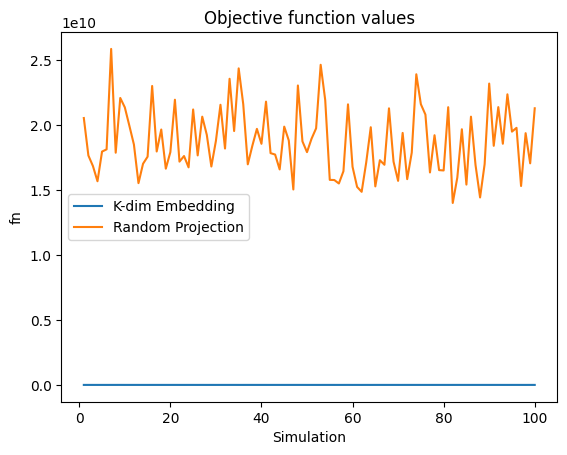

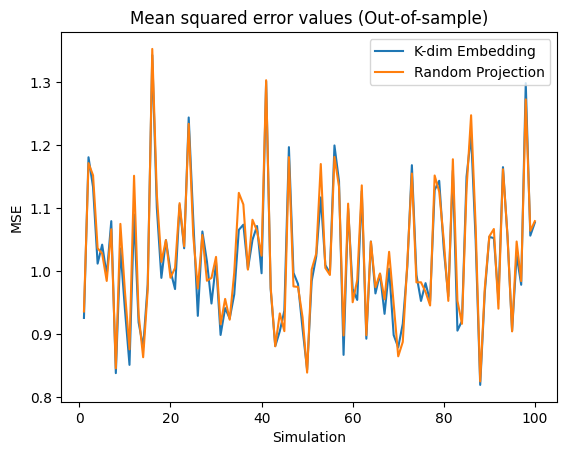

In [60]:
import matplotlib.pyplot as plt

# Plot 1: fn values for each simulation
fig, ax = plt.subplots()
for key, grp in results_df.groupby('Method'):
    ax = grp.plot(ax=ax, kind='line', x='Simulation', y='fn', label=key)
ax.set_xlabel('Simulation')
ax.set_ylabel('fn')
ax.set_title('Objective function values')
plt.show()

# Plot 2: MSE values for each simulation
fig, ax = plt.subplots()
for key, grp in results_df.groupby('Method'):
    ax = grp.plot(ax=ax, kind='line', x='Simulation', y='MSE', label=key)
ax.set_xlabel('Simulation')
ax.set_ylabel('MSE')
ax.set_title('Mean squared error values (Out-of-sample)')
plt.show()


### Resources and Notes {-}

1. 